The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

In [1]:
import glob
import cv2
from image_utils import *
from lane_utils import *
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
nx = 9
ny = 6
offset = 300
ym_per_pix = 30/720
xm_per_pix = 3.7/700
source_points = np.array([(200,720),(593,450),
                          (685,450), 
                          (1110,720)], dtype=np.float32)


destination_points = np.float32([[offset, 720], [offset, 0], 
                                     [1280-offset, 0], 
                                     [1280-offset, 720]])
mask_points = np.array([(150,720),(650,400),
                          (835,400), 
                          (1200,720)], dtype=np.float32)

In [4]:
camera_calibration_params = camera_calibration(nx,ny,'../camera_cal/calibration*.jpg', 1)

In [5]:
def image_lane_finding_pipeline(image, write_file = False, file_name = None):
    # Undistortion
    undistorted_image = image_undistortion(image, nx, ny, camera_calibration_params, write_file, file_name)
    
    # Sharpen image
    sharpened_image = image_sharpen(undistorted_image)
    
    # Binary Image    
    binary_image = create_binary_image(sharpened_image, mask_points, write_file, file_name)
    
    # Perspective transform    
    warpped_image_binary = create_or_inverse_perspective(binary_image, source_points, destination_points, False, True, "binary_" + file_name.split('/')[-1])
    warpped_image = create_or_inverse_perspective(undistorted_image, source_points, destination_points)
    undistorted_image_polygon = draw_polygon(undistorted_image, source_points, 
                                             True, "undistorted_" + file_name.split('/')[-1]) 
    warpped_image_polygon = draw_polygon(warpped_image, destination_points, 
                                         True, "warped_" + file_name.split('/')[-1])
    
    # Fit polynomial    
    image_lanes, image_lanes_plotted, ploty, left_fit, \
    right_fit, leftx_base, rightx_base = fit_polynomial(warpped_image_binary, write_file=write_file, 
                                                                                  write_file_name=file_name)
    
    # Compute radii and distance to center
    imshape = binary_image.shape
    radii = measure_curvature_real(ploty,ym_per_pix,xm_per_pix, left_fit, right_fit)
    dist_to_center = measure_distance_to_center(imshape, ploty, ym_per_pix, xm_per_pix, left_fit, right_fit)
    
    # Inverse perspective
    unwarped_image = fill_poly(undistorted_image, warpped_image_binary, ploty, left_fit, right_fit, 
                               source_points, destination_points)
    
    # Add radii and distance and save file
    final_frame = create_final_frame(unwarped_image, radii, dist_to_center, True, file_name)
    
    results = final_frame.copy()
    return results        

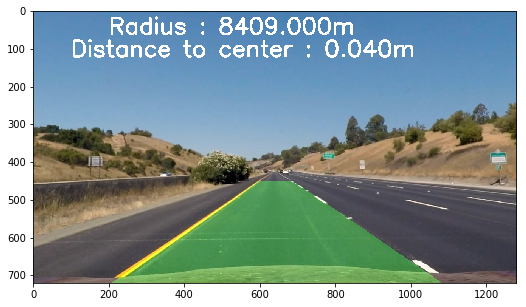

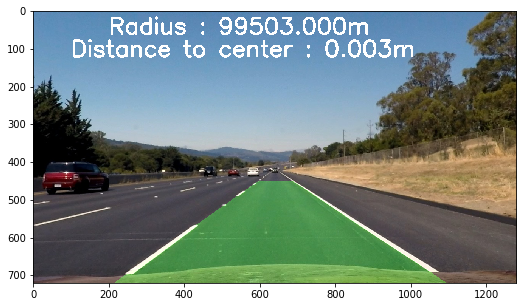

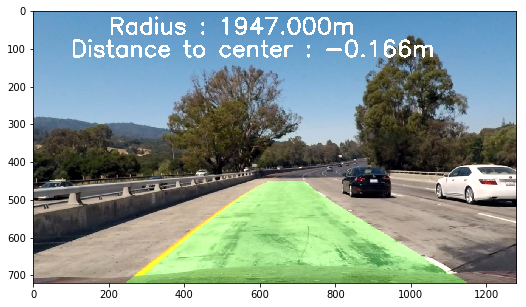

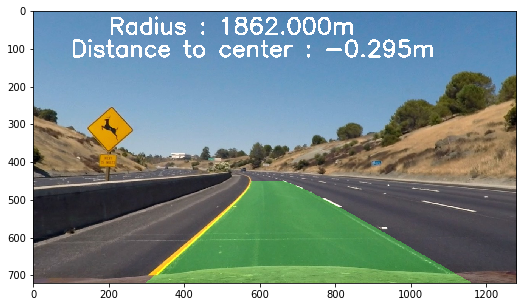

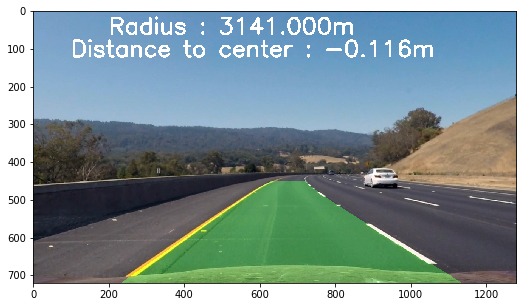

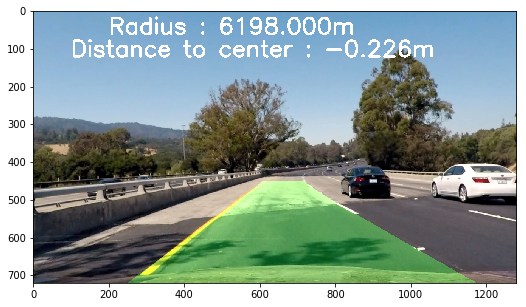

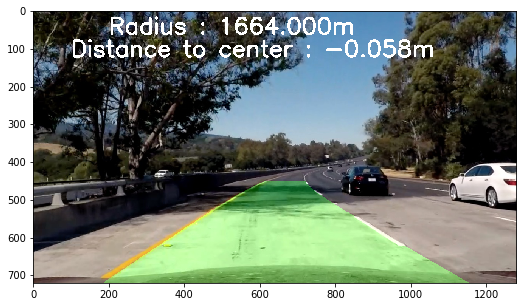

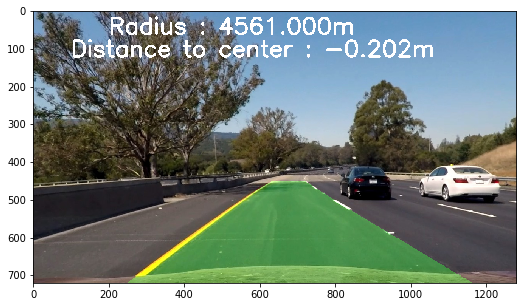

In [6]:
test_images = glob.glob('../test_images/*')

for image_name in sorted(test_images):
    image = cv2.imread(image_name)
    output_image = image_lane_finding_pipeline(image, True, image_name)
    show_image(output_image, 0)

### Process video

In [7]:
def video_lane_finding_pipeline(image, leftx_base=None, rightx_base=None, ploty = None,
                                left_fit = None, right_fit = None,
                                write_file = False, file_name = None):
    # Undistortion
    undistorted_image = image_undistortion(image, nx, ny, camera_calibration_params)
    
    # Sharpen image
    sharpened_image = image_sharpen(undistorted_image)
    
    # Smooth image
    smooth_image = cv2.GaussianBlur(sharpened_image, (5, 5), 1.0)
    
    # Binary Image    
    binary_image = create_binary_image(smooth_image, mask_points, write_file, file_name)
    
    # Perspective transform    
    wrapped_image_binary = create_or_inverse_perspective(binary_image, source_points, destination_points)
    wrapped_image = create_or_inverse_perspective(undistorted_image, source_points, destination_points)
    undistorted_image_polygon = draw_polygon(undistorted_image, source_points) 
    wrapped_image_polygon = draw_polygon(wrapped_image, destination_points)
    
    # Fit polynomial
    try:
        image_lanes, image_lanes_plotted, ploty, left_fit, right_fit, \
    leftx_base, rightx_base = fit_polynomial(wrapped_image_binary, leftx_base, rightx_base, ploty, left_fit, right_fit)
    except:
        return undistorted_image
    
    # Compute radii and distance to center
    imshape = binary_image.shape
    radii = measure_curvature_real(ploty,ym_per_pix,xm_per_pix, left_fit, right_fit)
    dist_to_center = measure_distance_to_center(imshape, ploty, ym_per_pix, xm_per_pix, left_fit, right_fit)
    
    # Inverse perspective
    unwarped_image = fill_poly(undistorted_image, wrapped_image_binary, ploty, left_fit, right_fit, 
                               source_points, destination_points)
    
    # Add radii and distance and save file
    final_frame = create_final_frame(unwarped_image, radii, dist_to_center)
    
    results = final_frame.copy()
    return (results, leftx_base, rightx_base, ploty, left_fit, right_fit)
        

In [8]:
selected_videos = ['../project_video.mp4','../challenge_video.mp4','../harder_challenge_video.mp4']

for video_file_name in selected_videos:
    print(video_file_name)
    clip2 = VideoFileClip(video_file_name)#.subclip(0,1)
    
    new_frames = []
    leftx_base = None
    rightx_base = None
    ploty = None
    left_fit = None
    right_fit = None
    for frame in tqdm(clip2.iter_frames()):
        results, leftx_base, rightx_base, ploty, left_fit, right_fit = video_lane_finding_pipeline(frame, leftx_base, rightx_base, ploty, left_fit, right_fit)
        new_frames.append(results)
        
    new_clip = ImageSequenceClip(new_frames, fps=clip2.fps)
    new_clip.write_videofile('../output_images/videos/output_' + video_file_name.split('/')[-1], audio=False)

../project_video.mp4


1260it [04:16,  4.76it/s]

[MoviePy] >>>> Building video ../output_images/videos/output_project_video.mp4
[MoviePy] Writing video ../output_images/videos/output_project_video.mp4



100%|██████████| 1260/1260 [02:08<00:00, 11.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/videos/output_project_video.mp4 

../challenge_video.mp4


485it [01:38,  4.73it/s]

[MoviePy] >>>> Building video ../output_images/videos/output_challenge_video.mp4
[MoviePy] Writing video ../output_images/videos/output_challenge_video.mp4



100%|██████████| 485/485 [00:38<00:00, 11.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/videos/output_challenge_video.mp4 

../harder_challenge_video.mp4


1199it [04:13,  4.86it/s]

[MoviePy] >>>> Building video ../output_images/videos/output_harder_challenge_video.mp4
[MoviePy] Writing video ../output_images/videos/output_harder_challenge_video.mp4



100%|██████████| 1199/1199 [02:38<00:00,  8.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_images/videos/output_harder_challenge_video.mp4 



In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('../output_images/videos/output_project_video.mp4'))

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('../output_images/videos/output_challenge_video.mp4'))

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('../output_images/videos/output_harder_challenge_video.mp4'))